Code cleaup. Need to 
1. remove repeated sentences due to vtt formatting
2. some words are concatenated together (helloBut--> hello But, swimming in a pool.We--> swimming in a pool. We)

In [ ]:
import glob
import json
import regex as re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus.reader import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

In [ ]:
with open('../channelHolisticInfo.json', 'r') as j:
    channelHolisticInfo = json.loads(j.read())
channelHolisticInfoDf = pd.DataFrame.from_dict(channelHolisticInfo)
channelHolisticInfoDf.head()

In [ ]:
LIST_OF_CHANNEL_IDS = channelHolisticInfoDf['channelId'].tolist()
LIST_OF_CHANNEL_NAMES = channelHolisticInfoDf['channelName'].tolist()
LIST_OF_VIDEO_COUNT = channelHolisticInfoDf['videoCount'].tolist()

In [ ]:
def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        duplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            duplicatedLinesList.append(strippedLines[index])
    return [i for n, i in enumerate(duplicatedLinesList) if i not in duplicatedLinesList[:n]]
# print(generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt"))

def generateListOfWords(listOfSentences):
    all_stopwords = list(stopwords.words('english'))
    cleanedListOfWords = []
    for words in listOfSentences:
        word = re.split('[?."(),!) ]', words)
        for wo in word:
            if wo !='' and wo not in all_stopwords:
                cleanedListOfWords.append(wo)
    return cleanedListOfWords

def flattenList(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

#wordCloud[channelId] = all words from all .txt files with no stopwords
#sentenceCloud[channelId] = all sentences from all .txt files.

wordCloud = {}
sentenceCloud = {}
for channelId in LIST_OF_CHANNEL_IDS:
    listOfSentences = []
    listOfWords = []
    print(channelId, "has ", len(glob.glob(channelId+"/txt/*.txt")), "files to process.")
    for txtFilePath in glob.glob(channelId+"/txt/*.txt"):
        listOfSentences.append(generateListOfSentences(txtFilePath))
    flattenedListOfSentences = flattenList(listOfSentences) #<--
    flattendListOfWords = generateListOfWords(flattenedListOfSentences)

    sentenceCloud[channelId.split('/')[0]] = flattenedListOfSentences
    wordCloud[channelId.split('/')[0]] = flattendListOfWords
    print(channelId.split('/')[0], ": ", len(flattenedListOfSentences), "sentences total")
    print(channelId.split('/')[0], ": ", len(flattendListOfWords), "words total")

    with open(channelId.split('/')[0]+"_wordCloud.txt", 'w') as f:
        json.dump(flattendListOfWords, f)
    with open(channelId.split('/')[0]+"_sentenceCloud.txt", 'w') as f:
        json.dump(flattenedListOfSentences, f)

In [ ]:
#Actually create sentences. Not chunks. 

def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        removeDuplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            removeDuplicatedLinesList.append(strippedLines[index])
        removeDuplicatedLinesList =[i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]
        # print(removeDuplicatedLinesList)
        passage = " ".join(removeDuplicatedLinesList)
        print(passage)
        # passageIntoSentences= split_into_sentences(str(passage))
        # print(passageIntoSentences)
    return [i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]

generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt")

Unfortunately, VADER works on sentences and what I have are fragments due to the nature of transcripts. I also tried simply detecting sentences in a punctuation-less passage but I think that takes a system that has a very good understanding of grammar and speech. There is a way to use NLTK to detect sentences in a passage if it has punctuation, but that case is straightforward.
As seen above, without punctuations to dictate where a sentence starts and ends, it's difficult to really know how to divide it up. So I'm just going to have to accept this shortcoming. For now.

# Holistically

In [ ]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

print(len(wordCloud.keys()))
for channelId in LIST_OF_CHANNEL_IDS:
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

In [ ]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

In [ ]:
print(df_positive_negative.label.value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

Basically, compared to redditors, animation youtubers are more 'positive'

# By Channel by words

In [ ]:
channelId_to_df = {}
sia = SIA()
for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_df[channelId] = df
df[150:200]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generateWordCloud(pos_words_str, neg_words_str):
    wordcloud_positive = WordCloud(background_color='white').generate(pos_words_str)
    wordcloud_negative = WordCloud().generate(neg_words_str)

    plt.imshow(wordcloud_positive, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.imshow(wordcloud_negative, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_df[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].words)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].words)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
print(scores)

# By sentences

In [ ]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for channelId in LIST_OF_CHANNEL_IDS:
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

# By channel by sentences

In [ ]:
sentenceCloud[LIST_OF_CHANNEL_IDS[28]]

In [ ]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
channelId_to_sentencedf = {}

for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_sentencedf[channelId] = df
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1


In [ ]:
from IPython.display import display

for channelId in LIST_OF_CHANNEL_IDS:
    display(channelId_to_sentencedf[channelId][200:250])

In [ ]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

In [ ]:
print(df_positive_negative.label.value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

In [ ]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_sentencedf[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].sentence)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].sentence)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
# print(scores)

channelName_to_scores = {}
for i in range(0, len(LIST_OF_CHANNEL_NAMES)):
    channelName_to_scores[LIST_OF_CHANNEL_NAMES[i]] = list(scores.values())[i]

avg_score=sum(channelName_to_scores.values())/len(LIST_OF_CHANNEL_NAMES)
print("avg score =", avg_score)
print(channelName_to_scores)
print(sorted(channelName_to_scores.items(), key=lambda item: item[1]))

In [ ]:
sorted_channelName_to_scores = dict(sorted(channelName_to_scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
%matplotlib widget

x_name = "Channel Name"
y_name = "Positivity :)"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores']
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


In [ ]:
num_of_files = []
for channelId in LIST_OF_CHANNEL_IDS:
    num_of_files.append(len(os.listdir(channelId+"/txt/")))
 
cntvdf = pd.DataFrame.from_dict({'channelName':LIST_OF_CHANNEL_NAMES, 'number of transcripts collected': num_of_files, 'number of vids': LIST_OF_VIDEO_COUNT})

cntvdf

In [ ]:
representation = sum(cntvdf['number of transcripts collected'])/sum(cntvdf['number of vids'])
print(representation)

In [ ]:
#https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
subsPerYearSinceFirstUpload = channelHolisticInfoDf['subscribersPerYearSinceFirstUpload']

In [ ]:
zipped = zip(channelHolisticInfoDf.channelName, channelHolisticInfoDf.subscribersPerYearSinceFirstUpload)
sorted_channelName_to_rescaledSubs = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
sctrs = pd.DataFrame.from_dict({'channelName': sorted_channelName_to_rescaledSubs.keys(), 'rescaledSubCount': sorted_channelName_to_rescaledSubs.values()})
sctrs

In [ ]:
x_name = "Channel"
y_name = "rescaledSubCount"
tooltip_name = "subCountPerYearSinceFirstUpload"

x= sctrs['channelName']
y= sctrs['rescaledSubCount']
tt = sctrs['rescaledSubCount']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

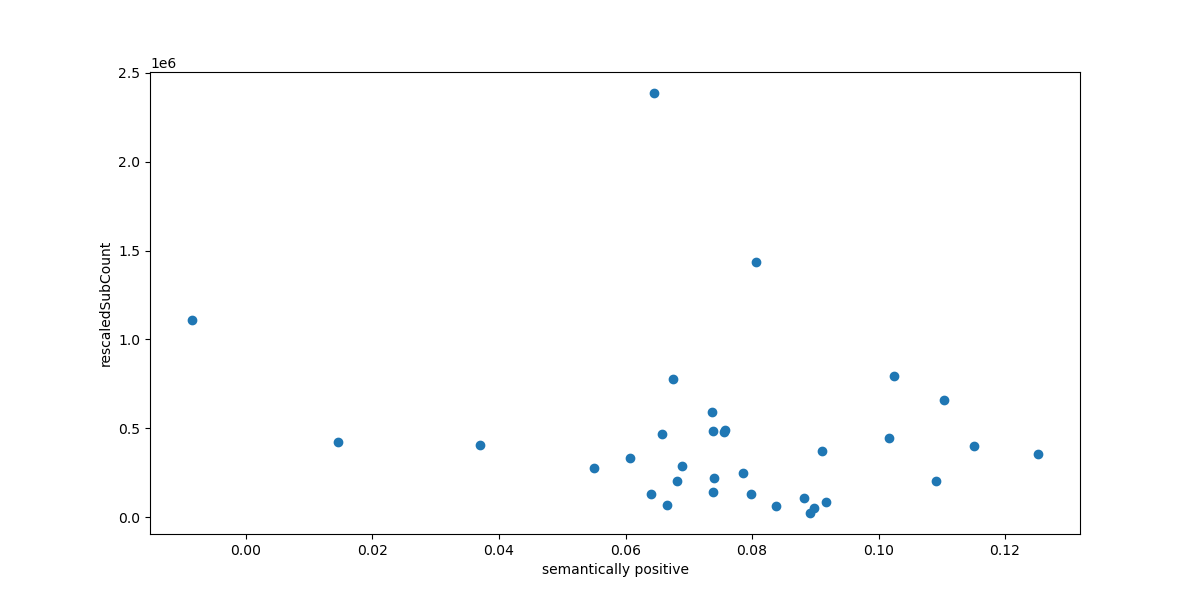

In [182]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
def generate_plot(semantic_df):
    x_name = "semantically positive"
    y_name = "rescaledSubCount"
    tooltip_name = "channelName"
    x= semantic_df['positivityScores']
    y= semantic_df['rescaledSubCount']
    tt = semantic_df[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
    # Plot the average line
    mean_x=np.arange(0,33,1)
    mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
    # mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details["positivityScores"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
generate_plot(semantic_df)

Pretty sure Oversimplified (and tbh, Odd1sOut) is messing up my calculations. 

In [ ]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
semantic_df

In [ ]:
import numpy as np
import pandas as pd
outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    index =0
    for y in data_1:
        print(y)
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append((index, y))
        index+=1
    return outliers
print(detect_outlier(subsPerYearSinceFirstUpload))
print(detect_outlier(list(channelName_to_scores.values())))

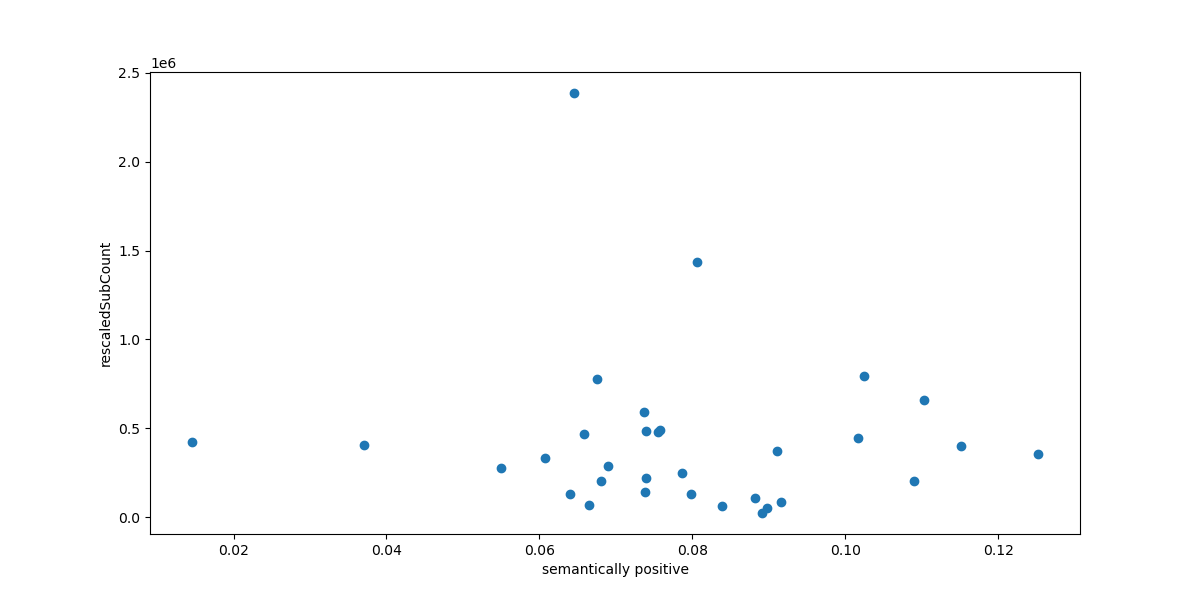

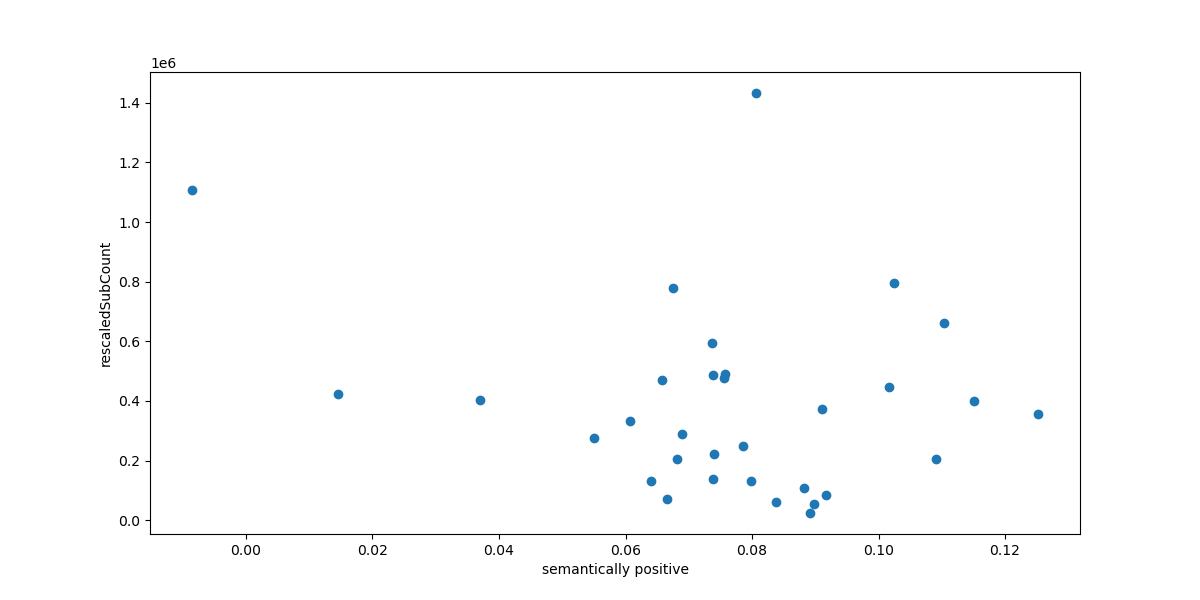

In [157]:
copy_without_oversimplified = semantic_df.drop('23')
copy_without_odd1sout = semantic_df.drop(['24'])
copy_without_oversimplified_and_odd1sout = semantic_df.drop(['23','24'])
semantic_df_copy_without_oversimplified = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_oversimplified.to_dict())))
semantic_df_copy_without_odd1sout = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_odd1sout.to_dict())))
semantic_df_copy_without_oversimplified_and_odd1sout = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_oversimplified_and_odd1sout.to_dict())))

generate_plot(semantic_df_copy_without_oversimplified)
generate_plot(semantic_df_copy_without_odd1sout)

So how exactly strong is the correlation? 

If the rvalue is close to 0, then literally, there's no relationship between how positive a channel is. Using rvalue instead of r^2 because I just have two terms

In [191]:
import numpy as np
import scipy.stats
x= 'rescaledSubCount'	
y= 'positivityScores'
result = scipy.stats.linregress(semantic_df[x], semantic_df[y])
result_no_oversimplified = scipy.stats.linregress(semantic_df_copy_without_oversimplified[x], semantic_df_copy_without_oversimplified[y])
result_no_odd1sout = scipy.stats.linregress(semantic_df_copy_without_odd1sout[x], semantic_df_copy_without_odd1sout[y])
result_no_oversimplified_and_odd1sout = scipy.stats.linregress(semantic_df_copy_without_oversimplified_and_odd1sout[x], semantic_df_copy_without_oversimplified_and_odd1sout[y])

print(result.rvalue)
print("removed positivity outlier: ", result_no_oversimplified.rvalue)
print("removed subCount outlier: ", result_no_odd1sout.rvalue)
print("removed both subCount and positivity outliers: ", result_no_oversimplified_and_odd1sout.rvalue)

-0.2071749572877416
removed positivity outlier:  -0.07678611344603309
removed subCount outlier:  -0.22544545509330252
removed both subCount and positivity outliers:  0.023909166953822544


Tbh, the results kind of suck. 
Need to test the null hypothesis
The null hypothesis is a typical statistical theory which suggests that **no statistical relationship and significance exists in a set of given single observed variable**, between two sets of observed data and measured phenomena.

In [173]:
result_polyfit_lst = []
for i in range(5):
    result_polyfit_lst.append(np.polyfit(semantic_df[x], semantic_df[y], i, full=True))
print([i for i in result_polyfit_lst])

[(array([0.07597388]), array([0.0224292]), 1, array([1.]), 7.327471962526033e-15), (array([-1.17929392e-08,  8.12187278e-02]), array([0.02146651]), 2, array([1.30255482, 0.55077303]), 7.327471962526033e-15), (array([ 7.36005838e-15, -2.70476842e-08,  8.50035159e-02]), array([0.02122847]), 3, array([1.52347189, 0.80039709, 0.19595383]), 7.327471962526033e-15), (array([ 1.18886487e-20, -3.14317219e-14,  8.48667031e-10,  8.10830920e-02]), array([0.02104798]), 4, array([1.74392193, 0.9376365 , 0.27889379, 0.04233632]), 7.327471962526033e-15), (array([-1.02651086e-26,  5.52715785e-20, -8.48011495e-14,  2.12539257e-08,
        7.93562756e-02]), array([0.0210285]), 5, array([1.96316634, 1.01496675, 0.3335451 , 0.06734939, 0.00566882]), 7.327471962526033e-15)]


! https://opentextbc.ca/researchmethods/chapter/understanding-null-hypothesis-testing/
A crucial step in null hypothesis testing is finding the likelihood of the sample result if the null hypothesis were true. This probability is called the p value. A low p value means that the sample result would be unlikely if the null hypothesis were true and leads to the rejection of the null hypothesis. A high p value means that the sample result would be likely if the null hypothesis were true and leads to the retention of the null hypothesis. But how low must the p value be before the sample result is considered unlikely enough to reject the null hypothesis? In null hypothesis testing, this criterion is called α (alpha) and is almost always set to .05. If there is less than a 5% chance of a result as extreme as the sample result if the null hypothesis were true, then the null hypothesis is rejected. When this happens, the result is said to be statistically significant. If there is greater than a 5% chance of a result as extreme as the sample result when the null hypothesis is true, then the null hypothesis is retained. This does not necessarily mean that the researcher accepts the null hypothesis as true—only that there is not currently enough evidence to conclude that it is true. Researchers often use the expression “fail to reject the null hypothesis” rather than “retain the null hypothesis,” but they never use the expression “accept the null hypothesis.”

> The Misunderstood p Value

> The p value is one of the most misunderstood quantities in psychological research (Cohen, 1994)[1]. Even professional researchers misinterpret it, and it is not unusual for such misinterpretations to appear in statistics textbooks!

> The most common misinterpretation is that the p value is the probability that the null hypothesis is true—that the sample result occurred by chance. For example, a misguided researcher might say that because the p value is .02, there is only a 2% chance that the result is due to chance and a 98% chance that it reflects a real relationship in the population. But this is incorrect. The p value is really the probability of a result at least as extreme as the sample result if the null hypothesis were true. So a p value of .02 means that if the null hypothesis were true, a sample result this extreme would occur only 2% of the time.

> You can avoid this misunderstanding by remembering that the p value is not the probability that any particular hypothesis is true or false. Instead, it is the probability of obtaining the sample result if the null hypothesis were true.

I need a z-statistic or a t-statistic.
What the f are those?
    A z-score, or z-statistic, is a number representing how many standard deviations above or below the mean population the score derived from a z-test is. Essentially, it is a numerical measurement that describes a value's relationship to the mean of a group of values.

It's the same thing as a z-score, I guess. So calculate and plot the z-score? and then what?

ok. too complicated.

I talked with my sister who just woke up for some suggestions. 

"Just square or log it"

"But I want to either prove or disprove that there is no correlation."

After a lengthy discussion of what p-values are, how to find causation between variables, what we wanted to eat for lunch and dinner, I googled a couple of things which eventually led me to this stackexchange post: https://stats.stackexchange.com/questions/99874/how-to-show-that-there-is-no-relationship

ACE. I was like whoa. And then omg somebody freakin implemented it already! And IT'S MIT LICENSE!!!!

In [208]:
from ace.samples import wang04
x, y = wang04.build_sample_ace_problem_wang04(N=200)
print(len(x), len(x[0]), len(y))
from ace import model
myace = model.Model()
myace.build_model_from_xy(x, y)
myace.eval([0.1, 0.2, 0.5, 0.3, 0.5])

5 200 200
* Starting outer iteration 000. Current err =  1.00000E+00
  Starting inner iteration 000. Current err =  1.00000E+00
  Starting inner iteration 001. Current err =  4.80949E-02
  Starting inner iteration 002. Current err =  1.94728E-02
  Starting inner iteration 003. Current err =  1.81404E-02
* Starting outer iteration 001. Current err =  8.85987E-03
  Starting inner iteration 000. Current err =  8.85987E-03
  Starting inner iteration 001. Current err =  6.10064E-03
  Starting inner iteration 002. Current err =  5.55106E-03
  Starting inner iteration 003. Current err =  5.49509E-03
  Starting inner iteration 004. Current err =  5.46719E-03
  Starting inner iteration 005. Current err =  5.43126E-03
  Starting inner iteration 006. Current err =  5.42857E-03
* Starting outer iteration 002. Current err =  4.61357E-03
  Starting inner iteration 000. Current err =  4.61357E-03
  Starting inner iteration 001. Current err =  4.51962E-03
  Starting inner iteration 002. Current err = 

1.6769073996579134

In [210]:
from ace import model
x= 'rescaledSubCount'	
y= 'positivityScores'
myace = model.Model()
print(len([semantic_df[x]]))
print(len([semantic_df[x]][0]))
print(len(semantic_df[y]))

myace.build_model_from_xy([semantic_df[x]], semantic_df[y])
myace.eval([0.1])

1
66
66
* Starting outer iteration 000. Current err =  1.00000E+00
  Starting inner iteration 000. Current err =  1.00000E+00
  Starting inner iteration 001. Current err =  9.43416E-01
* Starting outer iteration 001. Current err =  8.42343E-01
  Starting inner iteration 000. Current err =  8.42343E-01
  Starting inner iteration 001. Current err =  4.82805E-01
* Starting outer iteration 002. Current err =  3.64439E-01
  Starting inner iteration 000. Current err =  3.64439E-01


ValueError: A value in x_new is below the interpolation range.